# Trace Analysis 

This notebook performs some analysis on the trace files for the initial consensus experiments. 

In [2]:
%matplotlib inline

import os
import re
import csv
import glob
import pandas as pd
import seaborn as sns

In [22]:
## Load Data 

PROPRE = re.compile(r'^trace-(\d+)ms-(\d+)user.tsv$')
TRACES = os.path.join("..", "fixtures", "traces", "trace-*")

def load_data(traces=TRACES, pattern=PROPRE):
    for idx, name in enumerate(glob.glob(traces)):
        path = os.path.abspath(name)
        name = os.path.basename(name)
        prop = dict(zip(('access mean (ms)', 'users'), map(int, pattern.match(name).groups())))
        prop['id'] = idx + 1
        
        with open(path, 'r') as f:
            tstep = 0
            header = ('time', 'replica', 'object', 'access')
            reader = csv.DictReader(f, delimiter='\t', fieldnames=header)
            
            for row in reader:
                row.update(prop)
                row['time']  = int(row['time'])
                row['delay since last access (ms)'] = row['time'] - tstep 
                tstep = row['time']
                yield row

traces = pd.DataFrame(load_data())

## Trace Visualization

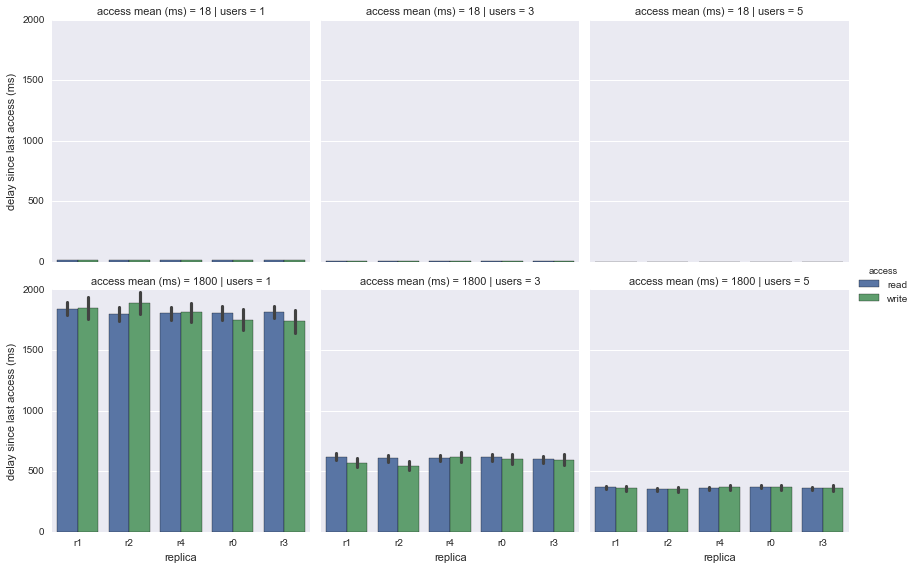

In [23]:
sns.factorplot(
    data=traces, x="replica", y="delay since last access (ms)", hue="access", 
    row='access mean (ms)', col='users', kind='bar'
)

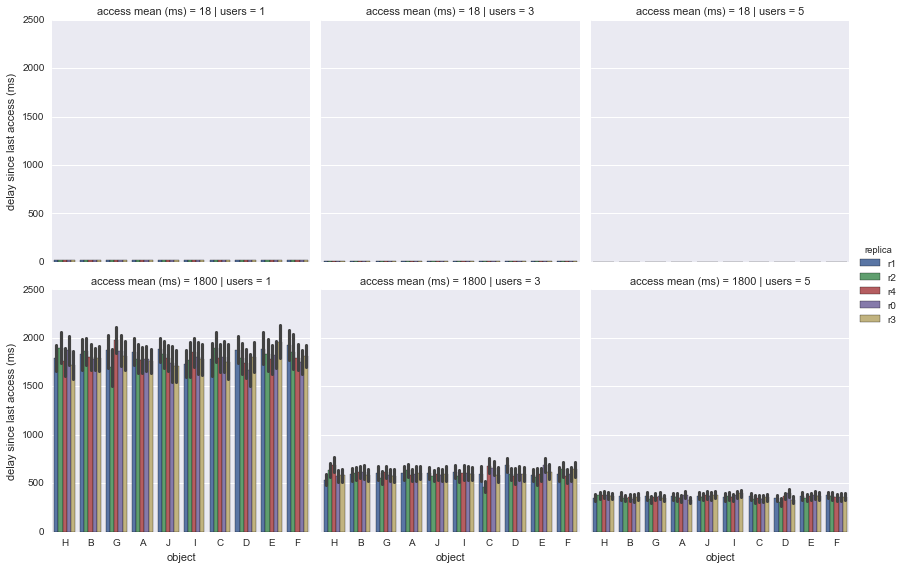

In [25]:
sns.factorplot(
    data=traces, x="object", y="delay since last access (ms)", hue="replica", 
    row='access mean (ms)', col='users', kind='bar'
)

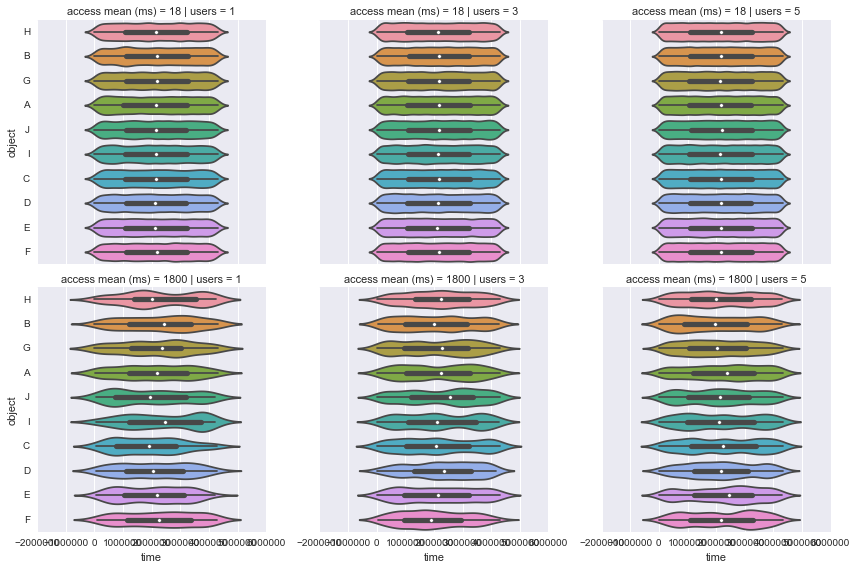

In [29]:
sns.factorplot(
    data=traces, x="time", y="object",
    row='access mean (ms)', col='users', kind='violin'
)